In [408]:
!pip install pandas matplotlib seaborn tensorflow Pillow scikit-learn

In [409]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential

from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


from tensorflow.keras.preprocessing import image

In [410]:
# Definir o tamanho das imagens 
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Caminho das imagens
base_path = "C:/Users/35196/Documents/archive/garbage_classification"

augmented_dir = "C:/Users/35196/Documents/archive/garbage_classification/augmentation"


# 4 classes
categories = {0: 'biological', 1: 'clothes', 2: 'shoes', 3: 'trash'}

In [411]:
# Função que tranforma isto "/paper104.jpg" em isto "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search(r"\d", x).start()] + '/' + x)


    return df

# Lista com os filenames do dataset
filenames_list = []

# Lista para guardar as categorias
categories_list = []

# Preenche as listas
# Corrige a construção do caminho
for category in categories:
    filenames = os.listdir(os.path.join(base_path, categories[category]))
    
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

# Atribui ao dataframe os valores
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# Chama a função para adicionar o nome na directoria
df = add_class_name_prefix(df, 'filename')

# Baralha o dataframe
df = df.sample(frac=1).reset_index(drop=True)




print('Número total de imagens do Dataset = ' , len(df))

Número total de imagens do Dataset =  10425


In [412]:
# Mostra as 5 primeiras
df.head()

,filename,category
0,trash/trash2195.jpg,3
1,shoes/shoes905.jpg,2
2,shoes/shoes383.jpg,2
3,shoes/shoes2426.jpg,2
4,trash/trash1081.jpg,3


shoes/shoes1870.jpg


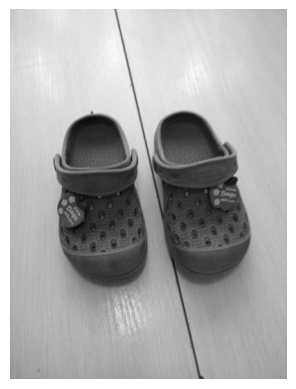

In [413]:
# Seleciona uma linha aleatória
random_row = random.randint(0, len(df) - 1)

sample = df.iloc[random_row]

# Carrega a imagem em escala de cinza
randomimage = image.load_img(os.path.join(base_path, sample['filename']), color_mode='grayscale')

# Exibe o nome do arquivo e a imagem
print(sample['filename'])
plt.imshow(randomimage, cmap='gray')
plt.axis('off')  #Não ter eixos para ser mais facil perceber a imagem
plt.show()  #  Mostra a imagem

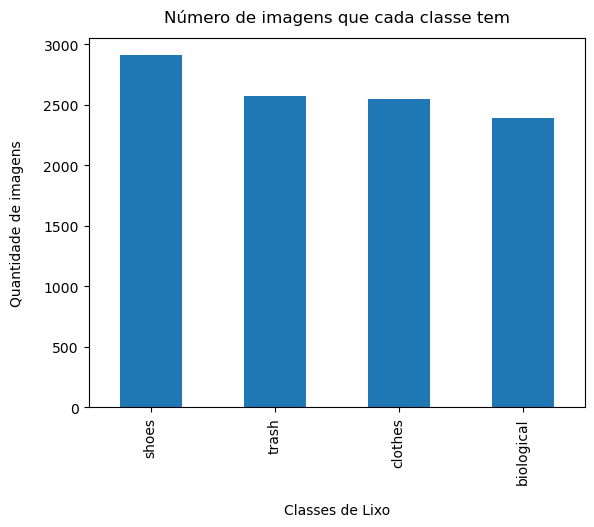

In [414]:
# Mostra quantas imagens cada classe tem. Dá jeito para confirmar que as imagens estão a ser todas reconhecidas
df_visualization = df.copy()

df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Classes de Lixo", labelpad=14)
plt.ylabel("Quantidade de imagens", labelpad=14)
plt.title("Número de imagens que cada classe tem", y=1.02);

In [415]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Parâmetros do modelo e treinamento
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
num_classes = len(categories)


# Modelo CNN otimizado
model = Sequential()

# Primeira camada convolucional 
model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Segunda camada convolucional 
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))  

# Terceira camada convolucional
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  
model.add(Dropout(0.2))

# Flatten para camada densa
model.add(Flatten())

# Camada densa com regularização L2 ajustada
model.add(Dense(128, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Camada de saída
model.add(Dense(num_classes, activation='softmax'))

# Compilação do modelo com Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['categorical_accuracy'])

# Resumo do modelo
model.summary()

C:\Users\35196\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,716 (24.60 MB)

 Trainable params: 6,447,236 (24.59 MB)

 Non-trainable params: 480 (1.88 KB)

In [416]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]



In [417]:
# Muda as categorias de numeros para nome
df["category"] = df["category"].replace(categories) 

# Dividimos o nosso dataset em treino, validação e teste, de modo a ter dados mais fidedignos e não
# tão tendenciosos. 80% para treino, 10% para validação e 10% para teste
# Ao dividir em validação permite-nos ver se o modelo está em overfitting, gera-nos outros dados que não
# os de treino
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True) 
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0] 
total_validate = validate_df.shape[0] 

print('Num Imagens de Treino = ', total_train , '  Num Imagens de Validação = ', total_validate, '  Num Imagens de Teste = ', test_df.shape[0])

Num Imagens de Treino =  8340   Num Imagens de Validação =  1042   Num Imagens de Teste =  1043


In [418]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
    
    ##  Augmentation End  ###
)



train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)
steps_per_epoch = len(train_df) // batch_size  # Número de batches
total_steps = steps_per_epoch * batch_size 


print(f"Total training samples: {len(train_df)}")
print(f"Total de exemplos processados por época: {total_steps}")

Found 8340 validated image filenames belonging to 4 classes.
Total training samples: 8340
Total de exemplos processados por época: 8320


In [419]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1042 validated image filenames belonging to 4 classes.


In [420]:
EPOCHS = 20
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\35196\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - categorical_accuracy: 0.6332 - loss: 1.2131 - val_categorical_accuracy: 0.6113 - val_loss: 1.2947
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.7344 - loss: 1.0335 - val_categorical_accuracy: 0.7778 - val_loss: 0.9608
Epoch 3/20


C:\Users\35196\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


130/130 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - categorical_accuracy: 0.7293 - loss: 0.9548 - val_categorical_accuracy: 0.6299 - val_loss: 1.1764
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - categorical_accuracy: 0.7812 - loss: 0.8217 - val_categorical_accuracy: 0.7222 - val_loss: 0.9677
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


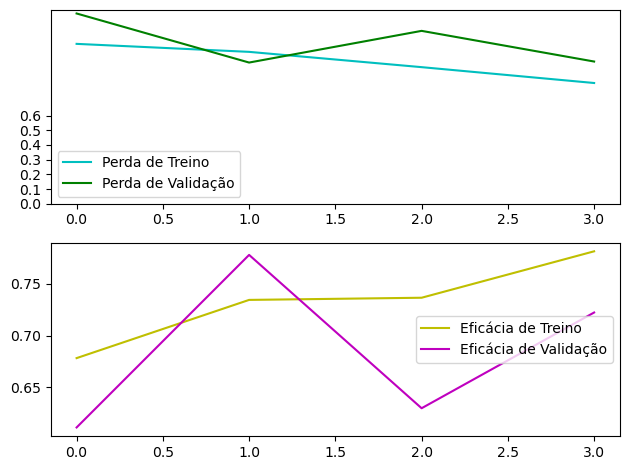

In [421]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='c', label="Perda de Treino")
ax1.plot(history.history['val_loss'], color='g', label="Perda de Validação")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='y', label="Eficácia de Treino")
ax2.plot(history.history['val_categorical_accuracy'], color='m',label="Eficácia de Validação")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [422]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1043 validated image filenames belonging to 4 classes.


In [423]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate(test_generator, steps=nb_samples)

print('Eficácia de teste = ',  round((accuracy * 100),2 ), '% ') 

   5/1043 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - categorical_accuracy: 0.8700 - loss: 0.8272

C:\Users\35196\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - categorical_accuracy: 0.6497 - loss: 1.2398
Eficácia de teste =  63.85 % 


In [424]:
# No inicio definimos as nossas proprias classes, no entanto, o gerador de treino gera as suas proprias
# Logo estas têm diferentes números para as nossas categorias/classes
# As previsões serão feitas com base no numero das classes do gerador

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'biological', 1: 'clothes', 2: 'shoes', 3: 'trash'}


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
              precision    recall  f1-score   support

  biological       0.49      0.94      0.65       231
     clothes       0.71      0.70      0.71       234
       shoes       0.83      0.13      0.22       315
       trash       0.76      0.93      0.84       263

    accuracy                           0.64      1043
   macro avg       0.70      0.67      0.60      1043
weighted avg       0.71      0.64      0.58      1043



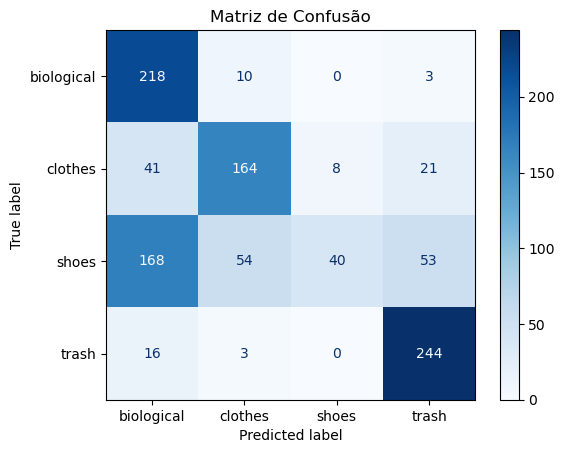

In [425]:
# Mete na previsão do modelo os nossos dados de teste
preds = model.predict(test_generator, steps=len(test_generator))

# Vais buscar o NUMERO da categoria com a probabilidade de previsão mais alta
preds_classes = preds.argmax(axis=1)  # Armazenar as classes previstas como índices

# Converter índices para nomes das classes usando o dicionário
preds_labels = [gen_label_map[item] for item in preds_classes]  # Mapeia índices para nomes

# Converte o dataframe para uma matriz
labels = test_df['category'].to_numpy()  # Assume que isso é uma lista de strings

# Exibe o relatório de classificação
print(classification_report(labels, preds_labels))

# Criar a matriz de confusão
cm = confusion_matrix(labels, preds_labels)  

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gen_label_map.values())
disp.plot(cmap=plt.cm.Blues)  
plt.title('Matriz de Confusão')
plt.show()
